# UNDERSTANDING DISATERS THROUGH SOCIAL MEDIA: AN NLP APPROACH
---

## Research Problem

Social media has become an essential communication platform, especially during emergencies. The widespread use of smartphones enables people to report emergencies in real-time, providing valuable information to disaster relief organizations, news agencies, and governmental bodies. However, distinguishing between genuine emergency tweets and unrelated messages poses a significant challenge.

Organizations that rely on social media for real-time disaster monitoring need an automated way to filter relevant information accurately. A machine learning model capable of distinguishing real disaster-related tweets from unrelated ones would enhance response times and resource allocation, ensuring efficient emergency management.



## Related Works in Brief

 Link: https://crisisnlp.qcri.org/

- Image-Based Disaster Response:  Alam et al. introduced MEDIC, the largest dataset of social media images for disaster response, containing over 71,000 images covering four disaster-related tasks in a multi-task learning setup. The dataset enhances model efficiency and generalization, and outperforms baselines with deep learning models ([1]).

- Social Media During COVID-19:
Imran et al. developed TBCOV, a multilingual dataset of over 2 billion COVID-19-related tweets from 87 million users in 67 languages. Using sentiment analysis, NER, gender classification, and geolocation, the study emphasized the power of social media for real-time public health monitoring and decision-making ([2]).

- Tweet-Based Impact Detection (Hurricane Irma):  Sit et al. proposed a framework using deep learning (LSTM), topic modeling (LDA), and spatial clustering to analyze over 500 million geo-tagged tweets. It successfully identified disaster impact on people and infrastructure, demonstrating spatial-temporal insight extraction from tweets ([3]).

- Help-Seeking Tweets (Hurricane Harvey): Powers et al. focused on detecting urgent, help-seeking tweets during Hurricane Harvey using pretrained models like BERT and XLNet. These outperformed CNNs and traditional classifiers, proving useful for first responders and emergency communication systems ([4]).

- Sentiment Analysis (Kerala Floods): Mendon et al. analyzed 243,746 tweets from the 2018 Kerala floods using a hybrid of machine learning, statistical modeling, and lexicon-based approaches. Their framework revealed sentiment trends, key influencers, and actionable disaster-related insights for authorities ([5]).

## Research Gap
Although many researchers have used AI to study disaster-related text data from social media, there are still some areas that are not well explored:

- Image data is underused – Most studies focus only on text like tweets, but images shared during disasters can also give important information. According to [1], this area still needs more research.

- Real-time analysis is limited – Many studies look at past disasters, but we need tools that work during a disaster to help first responders quickly.

- Lack of combined data – Very few studies use both text and images together. Combining them could give a better understanding of the situation.

- Challenges with Twitter data – Recent changes in Twitter’s policies have made it harder to collect data. This limits access to real-time or large-scale tweet data.


## Data Description
The dataset was sourced from crisis NLP data repository. It consists of tweets labeled as either related to a disaster (1) or not (0). It contains the following columns:

   - id: A unique identifier for each tweet.

   - keyword: A keyword extracted from the tweet (may be blank).

   - location: The location from which the tweet was sent (may be blank).

   - text: The actual content of the tweet, which serves as the main feature for NLP processing.

   - target: Present only in the training data, with values:

     - 1: The tweet is about a real disaster.

     - 0: The tweet is not related to a disaster.

# Implementation

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import collections
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import html
from html import unescape
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from scipy.sparse import hstack
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# NLTK Downloads
nltk.download('stopwords') #common words like "the","is"
nltk.download('words') #corpus of english words used for spell checking
nltk.download('wordnet')#lexical database for lemmatization
nltk.download('omw-1.4') #multilingual wordnet ->needed for wordnet to work properly

# Initializing NLP tools setup
tokenizer = RegexpTokenizer(r"(?:\w+[-']\w+|\w+)")  # Preserves hyphenated words and contractions
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'no', 'not', 'never'}


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# loading the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Make copies for safety
train = train_df.copy()
test = test_df.copy()

## Exploratory Data Analysis

### Data Overview

In [3]:
# Check train data structure
print("Train Data Shape:", train.shape)
print("\nTrain Data Columns:", train.columns)
print("\nTrain Data Info:")
train.info()

Train Data Shape: (7613, 5)

Train Data Columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


**Insights:**
- Presence of missing values in the keyword and location column.
- The text column is of the object data type thus we have to do some pre-processing.


In [4]:
# Display first few rows
print("\nTrain Data Sample:")
display(train.head())


Train Data Sample:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Missing Values

In [5]:
# Check missing values in train data
print("Train Data Missing Values:")
train.isnull().sum().loc[lambda x: x >0]


Train Data Missing Values:


,0
keyword,61
location,2533


**Insights:**
- Presence of missing values in the keyword and location column.
- Location column has the highest missing values.

### Target variable distribution

<ipython-input-6-1ed825c5992d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=train,palette=['#1f77b4', '#FF0000'])


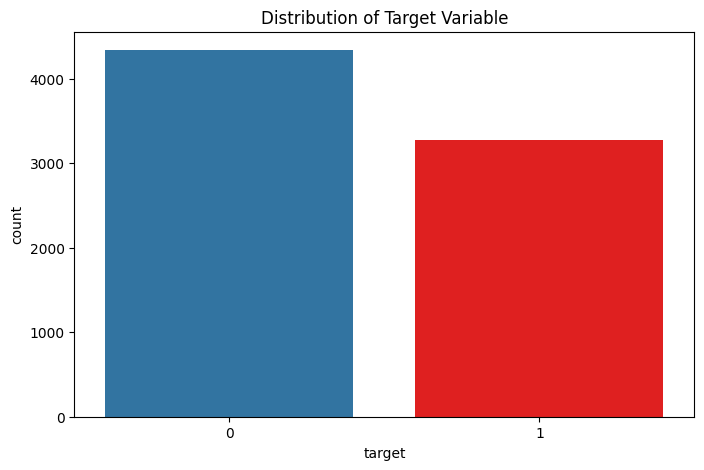

Target Value Counts:
target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


In [6]:
# Check target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=train,palette=['#1f77b4', '#FF0000'])
plt.title('Distribution of Target Variable')
plt.show()

# Percentage distribution
print("Target Value Counts:")
print(train['target'].value_counts(normalize=True))

**Insights:**
- Based on the dataset, l would not consider the above to be an imbalanced dataset. Since it is greater than the threshold of 6%

### Word clouds

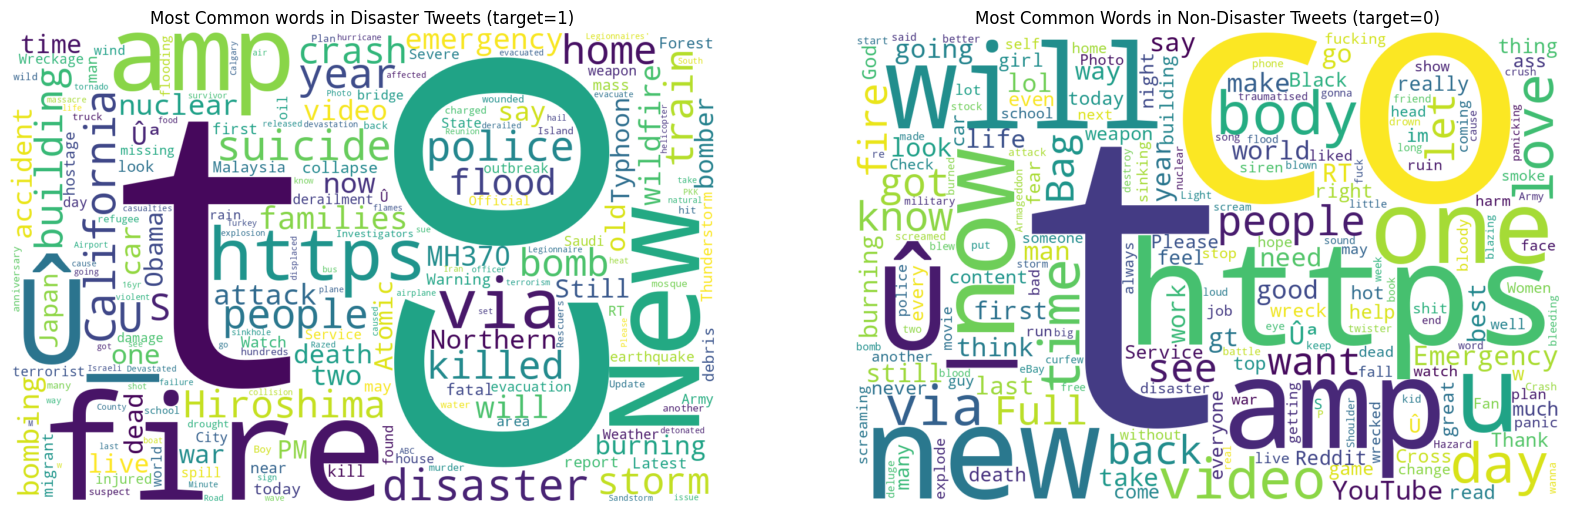

In [7]:
# Generating word cloud for disaster and non-disaster tweets
disaster_tweets = ' '.join(train[train['target']==1]['text'])
non_disaster_tweets = ' '.join(train[train['target']==0]['text'])

plt.figure(figsize=(20,10))

# Disaster tweets word cloud
plt.subplot(1,2,1)
wordcloud = WordCloud(width=1200, height=800,background_color="white",collocations=False).generate(disaster_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common words in Disaster Tweets (target=1)')

# Non-disaster tweets word cloud
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=1200, height=800,background_color="white",collocations=False).generate(non_disaster_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Non-Disaster Tweets (target=0)')


plt.show()



**Insights:**
- Disaster tweets commonly feature high-impact words like "disaster," "storm," "killed," "bomb," "emergency," and "accident", reflecting urgency and catastrophic events.

- Non-disaster tweets are filled with more casual, day-to-day words such as "video," "take," "one," "look," "got," and "know," suggesting a general or conversational tone.

- Terms like "California," "Hiroshima," "police," and "crash" appear frequently in disaster tweets, pointing to specific locations or incidents, while non-disaster tweets include words like "Bag," "life," "first," and "YouTube," which are less event-driven.

- Common internet-related words like "https," "amp," and "via" appear in both tweet types, likely due to links and formatting in tweets.

- The word "CO" is prominently present in both disaster and non-disaster tweets, but its context likely differs

In [8]:
# Filter tweets containing 'CO'
co_tweets = train[train['text'].str.contains(r'\bCO\b', case=False, na=False)]

# Separate into disaster and non-disaster
co_disaster = co_tweets[co_tweets['target'] == 1]
co_nondisaster = co_tweets[co_tweets['target'] == 0]

# Display a few samples from each
print("🔴 Disaster tweets containing 'CO':")
print(co_disaster['text'].head(5), '\n')

print("🟢 Non-disaster tweets containing 'CO':")
print(co_nondisaster['text'].head(5))


🔴 Disaster tweets containing 'CO':
31    @bbcmtd Wholesale Markets ablaze http://t.co/l...
33    #AFRICANBAZE: Breaking news:Nigeria flag set a...
37    INEC Office in Abia Set Ablaze - http://t.co/3...
38    Barbados #Bridgetown JAMAICA ÛÒ Two cars set ...
46    How the West was burned: Thousands of wildfire...
Name: text, dtype: object 

🟢 Non-disaster tweets containing 'CO':
32    We always try to bring the heavy. #metal #RT h...
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
40    Check these out: http://t.co/rOI2NSmEJJ http:/...
44    I wanted to set Chicago ablaze with my preachi...
45    I gained 3 followers in the last week. You? Kn...
Name: text, dtype: object


- In both disaster and non-disaster tweets, the word “CO” is not used meaningfully—it appears as part of Twitter’s URL shortener t.co

### Most common hashtags in tweets

In [9]:
# Function to extract hashtags
def extract_hashtags(text):
    return re.findall(r"#(\w+)", text)

# Extract hashtags from disaster and non-disaster tweets
disaster_hashtags = sum(train[train["target"] == 1]["text"].apply(extract_hashtags), [])
non_disaster_hashtags = sum(train[train["target"] == 0]["text"].apply(extract_hashtags), [])

# Count most common hashtags
disaster_hashtag_counts = collections.Counter(disaster_hashtags).most_common(10)
non_disaster_hashtag_counts = collections.Counter(non_disaster_hashtags).most_common(10)

print("Top 10 Hashtags in Disaster Tweets:", disaster_hashtag_counts, end="\n\n\n")

print("Top 10 Hashtags in Non-Disaster Tweets:", non_disaster_hashtag_counts)

Top 10 Hashtags in Disaster Tweets: [('News', 33), ('news', 23), ('Hiroshima', 21), ('hot', 13), ('prebreak', 13), ('best', 13), ('Japan', 10), ('India', 10), ('yyc', 10), ('Sismo', 9)]


Top 10 Hashtags in Non-Disaster Tweets: [('hot', 18), ('prebreak', 17), ('best', 17), ('news', 15), ('GBBO', 13), ('islam', 11), ('NowPlaying', 10), ('nowplaying', 10), ('jobs', 9), ('EDM', 8)]


- Overlap Exists: Hashtags like #hot, #prebreak, #best, and #news appear in both disaster and non-disaster tweets, indicating they are not strong indicators of tweet type on their own.

- Disaster-Specific Tags: Hashtags such as #Hiroshima, #Japan, #India, and #Sismo are more geographically or event-focused, and strongly associated with disaster tweets—they can serve as useful features for classification.

- Case Sensitivity Matters: The presence of both #News and #news among disaster hashtags suggests inconsistent casing in the data, which should be normalized during preprocessing (e.g., converting all hashtags to lowercase).

- Event Tags vs. Topic Tags: Disaster tweets tend to use hashtags tied to real-world events or crises, while non-disaster tweets use hashtags that reflect ongoing interests or personal experiences.

### Checking the text length

In [10]:
train["text_length"] = train["text"].apply(lambda x: len(x))
print("Real disaster tweet length", train[train['target'] == 1]['text_length'].mean())
print("Fake disaster tweet length", train[train['target'] == 0]['text_length'].mean())

Real disaster tweet length 108.11342097217977
Fake disaster tweet length 95.70681713496084


### Location Analysis

Number of unique locations: 3341


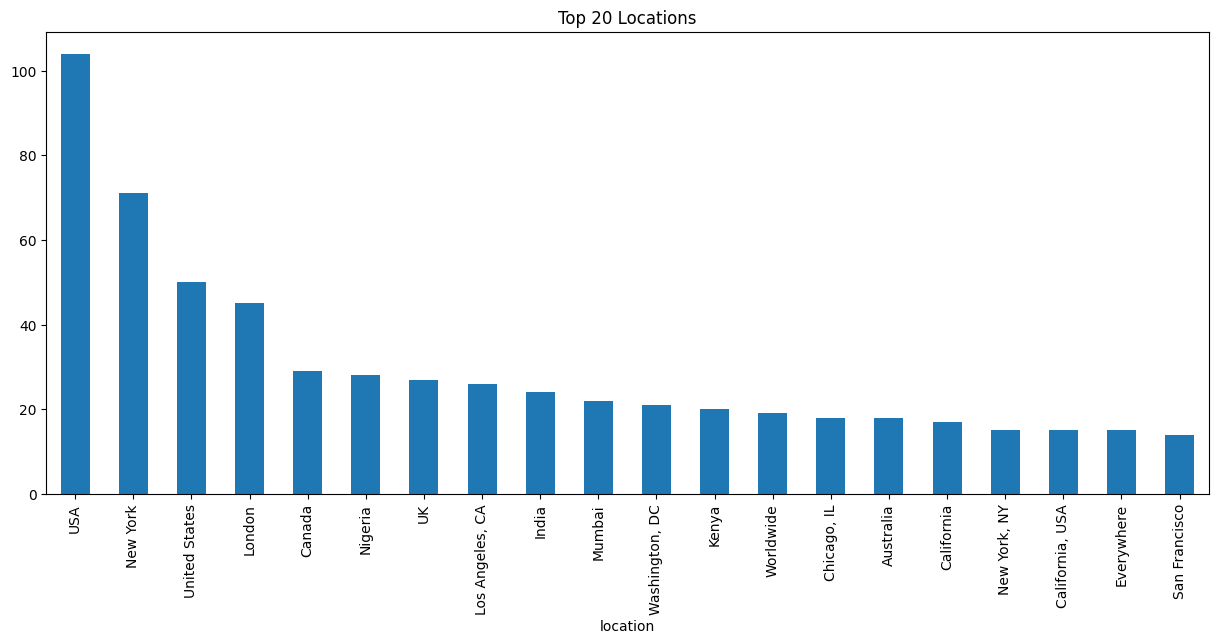

In [11]:
# Check unique locations
print("Number of unique locations:", train['location'].nunique())

# Top locations
plt.figure(figsize=(15, 6))
train['location'].value_counts()[:20].plot(kind='bar')
plt.title('Top 20 Locations')
plt.show()

**Insights:**
- The tweets were received from 3341 unique locations
- Most of the tweets were came from users based in the USA.

### Keywords Analysis

Top 10 Disaster Keywords:
keyword
derailment           1.000000
debris               1.000000
wreckage             1.000000
outbreak             0.975000
typhoon              0.973684
oil%20spill          0.973684
suicide%20bombing    0.969697
suicide%20bomber     0.967742
bombing              0.931034
rescuers             0.914286
Name: target, dtype: float64


<ipython-input-12-02543c3c5fe6>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_disaster_keywords.values, y=top_disaster_keywords.index, palette='Reds_r')


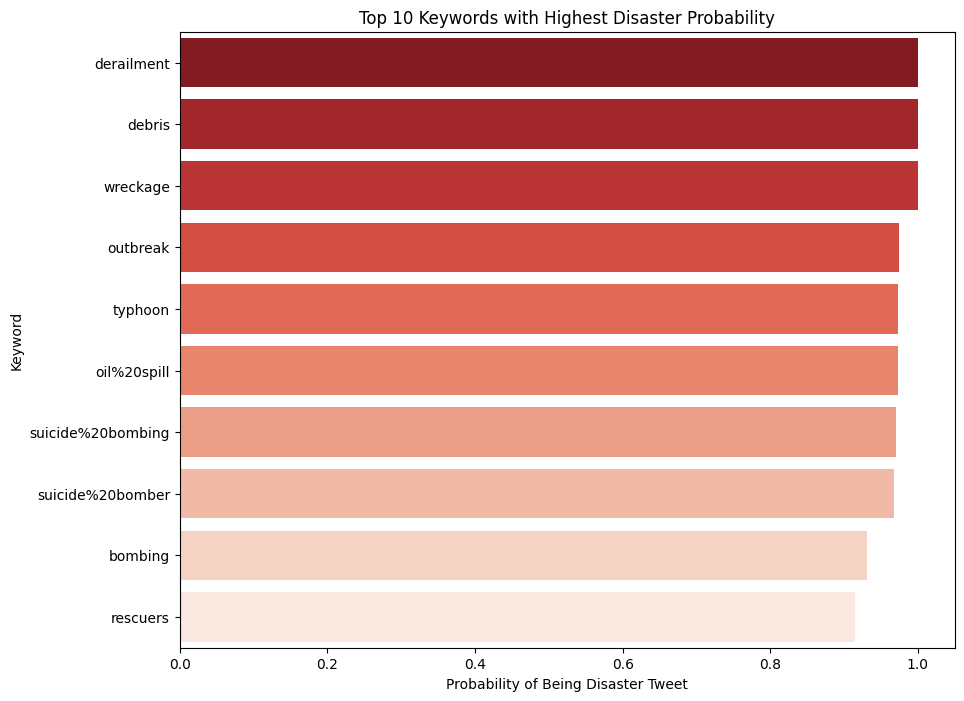

In [12]:
# Get top 10 disaster keywords
top_disaster_keywords = train.groupby('keyword')['target'].mean().sort_values(ascending=False).head(10)
print("Top 10 Disaster Keywords:")
print(top_disaster_keywords)

# Visualize top disaster keywords
plt.figure(figsize=(10, 8))
sns.barplot(x=top_disaster_keywords.values, y=top_disaster_keywords.index, palette='Reds_r')
plt.title('Top 10 Keywords with Highest Disaster Probability')
plt.xlabel('Probability of Being Disaster Tweet')
plt.ylabel('Keyword')
plt.show()

**Observations:**

- Words like "derailment," "debris," "wreckage," and "typhoon" have a near-100% probability of being linked to actual disasters.

- Rescuers at 91% makes sense as this term typically appears in disaster contexts


Bottom 10 Keywords (Least Likely to Be Disasters):
keyword
aftershock     0.000000
body%20bags    0.024390
ruin           0.027027
blazing        0.029412
body%20bag     0.030303
electrocute    0.031250
screaming      0.055556
traumatised    0.057143
panicking      0.060606
blew%20up      0.060606
Name: target, dtype: float64


<ipython-input-13-52f48fd480e2>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_keywords.values, y=bottom_keywords.index, palette='Blues_r')


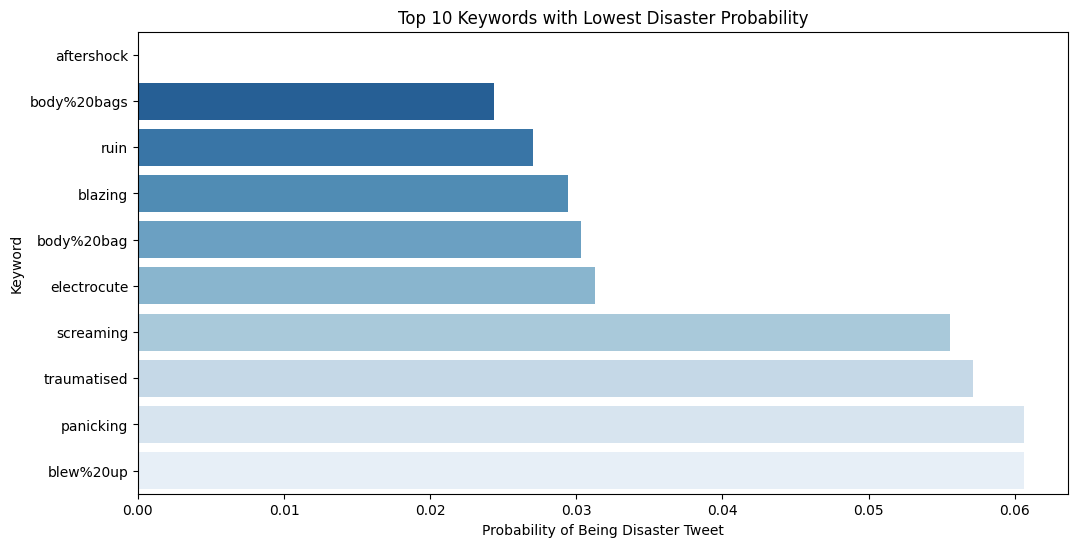

In [13]:
# Get bottom 10 disaster keywords
bottom_keywords = train.groupby('keyword')['target'].mean().sort_values().head(10)
print("\nBottom 10 Keywords (Least Likely to Be Disasters):")
print(bottom_keywords)

# Visualize bottom keywords
plt.figure(figsize=(12, 6))
sns.barplot(x=bottom_keywords.values, y=bottom_keywords.index, palette='Blues_r')
plt.title('Top 10 Keywords with Lowest Disaster Probability')
plt.xlabel('Probability of Being Disaster Tweet')
plt.ylabel('Keyword')
plt.show()

**Observations:**

- Words like "aftershock," "body%20bags," and "ruin" have very low disaster probabilities.


While keywords like 'derailment' strongly indicate disasters, their meaning depends on context - requiring NLP models to analyze both keywords and contextual intent to avoid misclassifying metaphorical language

In [14]:
# Example: Create disaster probability score based on keywords
keyword_probs = train.groupby('keyword')['target'].mean().to_dict()

train['keyword_score'] = train['keyword'].map(keyword_probs).fillna(0)
test['keyword_score'] = test['keyword'].map(keyword_probs).fillna(0)

In [15]:
# Example: Look at tweets with high-probability keywords but target=0 (potential mislabels)
high_prob_non_disaster = train[(train['keyword_score'] > 0.9) & (train['target'] == 0)]
print("\nHigh Probability Keywords but Labeled Non-Disaster:")
display(high_prob_non_disaster.sample(5, random_state=42)[['keyword', 'text', 'target']])

# And vice versa
low_prob_disaster = train[(train['keyword_score'] < 0.1) & (train['target'] == 1)]
print("\nLow Probability Keywords but Labeled Disaster:")
display(low_prob_disaster.sample(5, random_state=42)[['keyword', 'text', 'target']])


High Probability Keywords but Labeled Non-Disaster:


,keyword,text,target
1155,bombing,I think bombing Iran would be kinder... https:...,0
1157,bombing,Oh and fuck Bill Clinton for bombing us and fu...,0
5267,oil%20spill,@TroySlaby22 slicker than an oil spill,0
6453,suicide%20bombing,meek mill should join isis since he loves suic...,0
6422,suicide%20bomber,I liked a @YouTube video from @noahj456 http:/...,0



Low Probability Keywords but Labeled Disaster:


,keyword,text,target
7602,NaN,a siren just went off and it wasn't the Forney...,1
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
7597,NaN,#??? #?? #??? #??? MH370: Aircraft debris foun...,1
915,bloody,'I came to kill Indians...for FUN': Video of s...,1
12,NaN,#raining #flooding #Florida #TampaBay #Tampa 1...,1


- The result above illustrate the importance of understanding the context.

### Investigating what the text contains

In [16]:
idx = ~(train["keyword"].isna())
print(train.loc[idx, ["keyword", "text"]])
# keyword is a specific word extracted from the text
# which is unique and so important for prediction

      keyword                                               text
31     ablaze  @bbcmtd Wholesale Markets ablaze http://t.co/l...
32     ablaze  We always try to bring the heavy. #metal #RT h...
33     ablaze  #AFRICANBAZE: Breaking news:Nigeria flag set a...
34     ablaze                 Crying out for more! Set me ablaze
35     ablaze  On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
...       ...                                                ...
7578  wrecked   @jt_ruff23 @cameronhacker and I wrecked you both
7579  wrecked  Three days off from work and they've pretty mu...
7580  wrecked  #FX #forex #trading Cramer: Iger's 3 words tha...
7581  wrecked  @engineshed Great atmosphere at the British Li...
7582  wrecked  Cramer: Iger's 3 words that wrecked Disney's s...

[7552 rows x 2 columns]


In [17]:
# examining some texts
temp_text = train.loc[43, "text"]
print(temp_text)
tokenised_temp_text = tokenizer.tokenize(temp_text)
tokenised_temp_text

SOOOO PUMPED FOR ABLAZE ???? @southridgelife


['SOOOO', 'PUMPED', 'FOR', 'ABLAZE', 'southridgelife']

**Insights:**

Based on the above, we can see that the text contains:
- hashtags(#, @)
- contractions
- uppercase words
- links

## Data Cleaning

In [18]:
train.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_length',
       'keyword_score'],
      dtype='object')

In [19]:
# Dropping unnecessary columns
train.drop(['id','text_length','keyword_score'], axis=1, inplace=True)

In [20]:
train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
# Key words cleaning
def keyword_cleanup(data):
    n_nan = data[data['keyword'].isna()].shape[0]
    print(f"There are {n_nan} nan values in keyword. ")

    #replacing the NaN values with unk
    data["keyword"] = data["keyword"].fillna("unk") # just a common tag

    #1 Possible improvement: experiment with keywords split (maybe, two columns, etc)
    data["keyword"] = data["keyword"].apply(lambda x: x.replace("%20", "_"))

    # Possible improvement: replace synonymous keywords for even greater generalisation.
    # I don't lemmatise keywords because cross_val_score shows it decreases performance.
    # data["keyword"] = data["keyword"].apply(lambda x: lemmatise_word(x))

    return data

train = keyword_cleanup(train)

There are 61 nan values in keyword. 


In [22]:
# Locations clean up

def process_locations(data):
    # Mapping dictionary for standardizing locations
    # If occurence is low -> mapping into bigger locations (states, countries)
    location_mapping = {
        # United States and cities
        'usa': 'USA',
        'united states': 'USA',
        'us': 'USA',
        'california': 'California, USA',
        'california, usa': 'California, USA',
        'california, united states': 'California, USA',
        'southern california': 'California, USA',
        'florida': 'Florida, USA',
        'florida, usa': 'Florida, USA',
        'texas': 'Texas, USA',
        'texas, usa': 'Texas, USA',

        'new york': 'New York City, USA',
        'london': 'London, UK',
        'mumbai': 'Mumbai, Asia',
        'washington, dc': 'Washington DC, USA',
        'los angeles, ca': 'Los Angeles, USA',

        'new york, ny': 'New York City, USA',
        'nyc': 'New York City, USA',
        'new york city': 'New York City, USA',
        'brooklyn, ny': 'New York City, USA',
        'ny': 'New York City, USA',
        'los angeles': 'Los Angeles, USA',
        'washington, d.c.': 'Washington DC, USA',
        'chicago, il': 'Chicago, USA',
        'chicago': 'Chicago, USA',
        'san francisco': 'San Francisco, USA',
        'san francisco, ca': 'San Francisco, USA',
        'atlanta, ga': 'Atlanta, USA',
        'atlanta': 'Atlanta, USA',
        'seattle': 'Washington DC, USA',
        'seattle, wa': 'Washington DC, USA',
        'nashville, tn': 'Tennessee',
        'sacramento, ca': 'California, USA',
        'dallas, tx': 'Texas, USA',
        'houston, tx': 'Texas, USA',
        'orlando, fl': 'Florida, USA',
        'denver, colorado': 'Colorado, USA',
        'denver, co': 'Colorado, USA',
        'san diego, ca': 'California, USA',
        'charlotte, nc': 'USA',
        'portland, or': 'USA',
        'portland, oregon': 'USA',
        'tampa, fl': 'Florida, USA',
        'memphis, tn': 'Tennessee',
        'austin, tx': 'USA',
        'oklahoma city, ok': 'USA',
        'cleveland, oh': 'USA',
        'san jose, ca': 'California, USA',
        'colorado': 'Colorado, USA',
        'pennsylvania, usa': 'USA',
        'tennessee': 'Tennessee',

        'uk': 'UK',
        'united kingdom': 'UK',
        'london, uk': 'London, UK',
        'london, england': 'London, UK',
        'manchester': 'UK',
        'scotland': 'UK',
        'newcastle': 'UK',

        'canada': 'Canada',
        'toronto': 'Canada',
        'vancouver, bc': 'Canada',
        'calgary, alberta': 'Canada',
        'calgary, ab': 'Canada',

        'india': 'Asia',
        'nigeria': 'Nigeria',
        'kenya': 'Kenya',
        'indonesia': 'Indonesia',
        'ireland': 'UK',
        'australia': 'Australia',
        'south africa': 'Africa',
        'africa': 'Africa',
        'morioh, japan': 'Asia',
        'tokyo': 'Asia',
        'lagos': 'Nigeria',
        'sydney': 'Australia',
        'sydney, australia': 'Australia',
        'melbourne': 'Australia',

        'china': 'Asia',
        'italy': 'UK',
        'pakistan': 'Asia',
        'philippines': 'Indonesia',
        'singapore': 'Indonesia',

        'brasil': 'UNK',
        'worldwide': 'UNK',
        'everywhere': 'UNK',
        'earth': 'UNK',
        'world': 'UNK',
        'global': 'UNK',
        '304': 'UNK',
        'planet earth': 'UNK',
        '??????': 'UNK',
        ' road to the billionaires club': 'UNK',
        'pedophile hunting ground': 'UNK',
        'ss': 'UNK',
    }

    # Fill NA values with 'UNK'
    data['location'] = data['location'].fillna('UNK')

    # Convert to lowercase for matching
    data['location'] = data['location'].str.lower()

    # Replace locations using the mapping
    data['location'] = data['location'].apply(
        lambda x: location_mapping.get(x, "unk")
    )

    print(f"Locations after processing: {data['location'].nunique()} unique values")
    return data


train = process_locations(train)

Locations after processing: 24 unique values


In [23]:
# Splitting the data into train and test
#X_train, X_val, y_train, y_val = train_test_split(train.drop('target', axis=1), train['target'], test_size=0.2, random_state=123)

In [24]:
train1=train.copy()
train2=train.copy()
train3=train.copy()

### Attempt 1: With Lemmatization

In [25]:
# Performing preprocessing on the text column
def preprocess_text(text):
    """Function to convert text data into a format suitable for ML tasks."""
    if not text or str(text).strip() == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (but keep the text)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove numbers (optional - comment out if needed)
    text = re.sub(r'\d+', '', text)

    # Remove special characters but keep spaces
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Custom stopwords removal (keeping negations)
    custom_stopwords = set(stopwords.words('english')) - {
        'not', 'no', 'never', 'nor', 'none', 'neither'
    }
    tokens = [word for word in tokens if word not in custom_stopwords]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join back into string
    return ' '.join(tokens)

In [26]:
for col in ['text']:
    train1[col] = train1[col].astype(str).apply(preprocess_text)

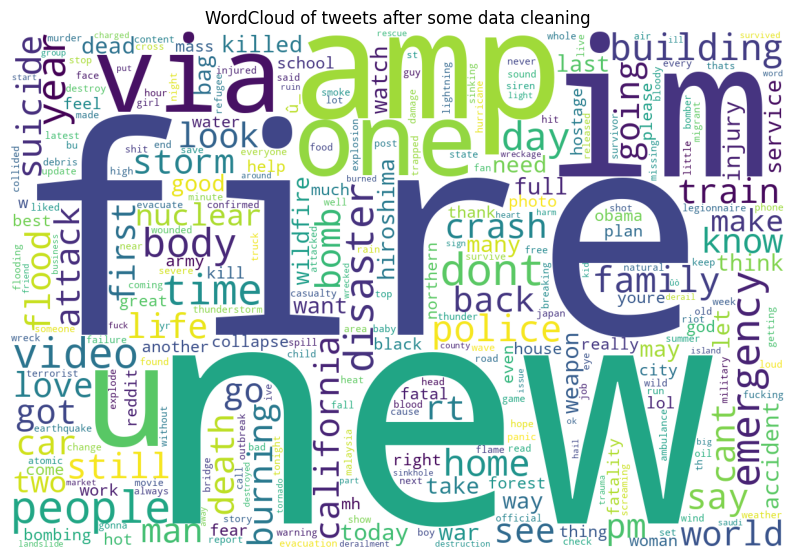

In [27]:
# Drawing a wordcloud
plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height = 800, background_color="white",collocations=False).generate(" ".join(train1.text))

plt.grid(None)
plt.title('WordCloud of tweets after some data cleaning')
plt.axis('off')
plt.imshow(wordcloud)

#### Creating models

In [28]:
# 1. Word to Vector (TF-IDF)Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,          # Increased from 5000 to capture more features
    ngram_range=(1, 3),          # Extended to include trigrams
    stop_words='english',
    min_df=3,                    # More aggressive than min_df=5
    max_df=0.6,                  # Slightly lower than 0.7 to filter more common terms
    analyzer='word',             # Explicitly use word analysis
    sublinear_tf=True,           # Use 1 + log(tf) instead of raw counts
    norm='l2'                    # Normalize vectors
)

# Convert tokens back to text (space-separated strings)
#train_texts = train['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Fit and transform
X_tfidf = tfidf.fit_transform(train1['text'])

# 2. Enhanced train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf,
    train1['target'],
    test_size=0.2,
    random_state=42,
    stratify=train1['target']
)

In [29]:
# Logistic Regression with optimized settings
logreg = LogisticRegression()

# Train model
logreg.fit(X_train, y_train)

# Evaluation
val_preds = logreg.predict(X_val)
print("Validation Set Classification Report Logistic Regression (With lemmatization):")
print(classification_report(y_val, val_preds, target_names=['Not Disaster', 'Disaster']))

Validation Set Classification Report Logistic Regression (With lemmatization):
              precision    recall  f1-score   support

Not Disaster       0.80      0.91      0.85       869
    Disaster       0.85      0.69      0.76       654

    accuracy                           0.81      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.81      0.81      1523



In [30]:
# Initiate the model
rf = RandomForestClassifier()
# fitting the model
rf.fit(X_train, y_train)

# Evaluate
val_preds = rf.predict(X_val)
print("Validation Set Classification Report Random Forest (With lemmatization):")
print(classification_report(y_val, val_preds, target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Random Forest (With lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.79      0.86      0.83       869
    Disaster       0.79      0.70      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [31]:
# Train (scale_pos_weight adjusts for class imbalance)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Evaluate
val_preds = xgb.predict(X_val)
print("Validation Set Classification Report Xgboost (With lemmatization):")
print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Xgboost (With lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.77      0.90      0.83       869
    Disaster       0.83      0.64      0.72       654

    accuracy                           0.79      1523
   macro avg       0.80      0.77      0.78      1523
weighted avg       0.79      0.79      0.78      1523



In [32]:
# Train
svm = LinearSVC(C=1.0, class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)

# Evaluate
val_preds = svm.predict(X_val)
print("Validation Set Classification Report SVM Classifier (With Lemmatization):")
print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report SVM Classifier (With Lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.81      0.80      0.80       869
    Disaster       0.74      0.75      0.74       654

    accuracy                           0.78      1523
   macro avg       0.77      0.78      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [33]:
# Multinomial Naive Bayes

# Initialize Multinomial Naive Bayes
nb = MultinomialNB()

# Train
nb.fit(X_train, y_train)  # X_train should be a count/TF-IDF matrix

# Evaluate
val_preds = nb.predict(X_val)
print("Validation Set Classification Report Multinomial Naive Bayes (With lemmatization) :")
print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Multinomial Naive Bayes (With lemmatization) :
              precision    recall  f1-score   support

Non-Disaster       0.77      0.93      0.84       869
    Disaster       0.87      0.64      0.74       654

    accuracy                           0.80      1523
   macro avg       0.82      0.78      0.79      1523
weighted avg       0.82      0.80      0.80      1523



### Attempt 2: Without Lemmatization

In [34]:
## Checking present HTML Entities in the dataset

import re
from collections import Counter

def find_html_entities(text_series, top_n=100):
    """
    Find and count HTML/XML entities in a pandas Series of text
    """
    # Pattern to match HTML/XML entities
    entity_pattern = re.compile(r'&[a-zA-Z0-9#]+;')

    # Find all entities
    all_entities = []
    for text in text_series:
        entities = entity_pattern.findall(str(text))
        all_entities.extend(entities)

    # Count entity frequencies
    entity_counts = Counter(all_entities)

    # Display most common
    print(f"\nTop {top_n} HTML Entities Found:")
    for entity, count in entity_counts.most_common(top_n):
        print(f"{entity}: {count} occurrences")

    return entity_counts

# Check training data
train_entities = find_html_entities(train2['text'])



Top 100 HTML Entities Found:
&amp;: 342 occurrences
&gt;: 88 occurrences
&lt;: 27 occurrences


In [35]:
# 1. Handle missing values
# train['keyword'] = train['keyword'].fillna('unknown')
# train['location'] = train['location'].fillna('unknown')

#=================================================Basic Cleaning==============================================================================

# 2. Text cleaning function: (Basic Cleaning)
def clean_text(text):
    """Comprehensive text cleaning function"""
    # Convert HTML entities first
    text = unescape(text)

    # Custom replacements for common entities
    html_entity_replacements = {
        r'&amp;\s*': ' and ',
        r'&gt;': ' > ',
        r'&lt;': ' < ',
        r'&\w+;': ' ',
    }

    for pattern, replacement in html_entity_replacements.items():
        text = re.sub(pattern, replacement, text)

    # Remove URLs and mentions
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = text.replace('#', ' ')

    # Keep basic punctuation and alphanumerics
    text = re.sub(r"[^a-zA-Z0-9'\-<>.,!? ]", ' ', text)

    # Handle specific cases
    #text = re.sub(r'\b(\w+)\.(\w+)\b', r'\1 \2', text)  # Split words joined by .

    # Final cleanup
    return re.sub(r'\s+', ' ', text).strip().lower()

# Apply cleaning
train2['clean_text'] = train2['text'].apply(clean_text)


#=======================================================NLTK Components=================================================================================
# NLTK setup
stop_words = set(stopwords.words('english'))
negation_words = {
    'no', 'not', 'nor', 'neither', 'never', 'none'
}
custom_stopwords = stop_words - negation_words
tokenizer = RegexpTokenizer(r"(?:\w+[-']\w+|\w+)")  # Preserves hyphenated words and contractions

# 4. Tokenization function
def tokenize_text(text):
    """Advanced tokenization preserving special word forms"""
    tokens = tokenizer.tokenize(text)

    return [
        word for word in tokens
        if (word not in custom_stopwords and len(word) > 1) or word.isdigit()
    ]

# Apply tokenization
train2['tokens'] = train2['clean_text'].apply(tokenize_text)

# 5. Verification output
print("\n=== Processing Pipeline Verification ===")
print(f"Original text ({len(train2['text'].iloc[0])} chars):\n{train2['text'].iloc[0]}")
print(f"\nCleaned text ({len(train2['clean_text'].iloc[0])} chars):\n{train2['clean_text'].iloc[0]}")
print(f"\nTokenized ({len(train2['tokens'].iloc[0])} tokens):\n{train2['tokens'].iloc[0]}")


=== Processing Pipeline Verification ===
Original text (69 chars):
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all

Cleaned text (68 chars):
our deeds are the reason of this earthquake may allah forgive us all

Tokenized (7 tokens):
['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']


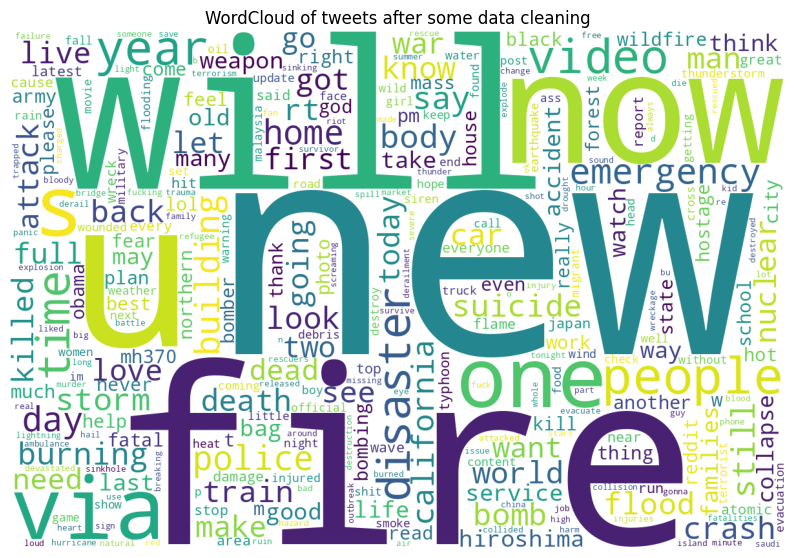

In [36]:
plt.figure(figsize=(10,8))
wordcloud = WordCloud(max_words=300, width=1200, height = 800, background_color="white",collocations=False).generate(" ".join(train2.clean_text))

plt.grid(None)
plt.title('WordCloud of tweets after some data cleaning')
plt.axis('off')
plt.imshow(wordcloud)

**Insights:**
- Dominant Theme of Disaster: The most prominent words ("fire","new," "will,"  "disaster," "emergency") strongly indicate the tweets center around a significant disaster or emergency situation.
- Focus on Recent Events: The large size of "new" suggests the tweets are primarily concerned with reporting on recent developments and unfolding events.
- Emphasis on Impact and Consequences: Words like "people," "injured," "death," and "building" highlight the human and physical impact of the events being discussed.
- Expression of Reactions and Needs: Words such as "hope," "feel," "need," and "help" reveal emotional responses and calls for assistance related to the situation.
- Potential Specific Incidents: While general disaster terms dominate, some smaller words (e.g., "Japan," "mh370") might hint at specific events or locations being referenced, though this requires further context.

In [37]:
# 1. Improved TF-IDF Vectorization
tfidf = TfidfVectorizer(
    max_features=10000,          # Increased from 5000 to capture more features
    ngram_range=(1, 3),          # Extended to include trigrams
    stop_words='english',
    min_df=3,                    # More aggressive than min_df=5
    max_df=0.6,                  # Slightly lower than 0.7 to filter more common terms
    analyzer='word',             # Explicitly use word analysis
    sublinear_tf=True,           # Use 1 + log(tf) instead of raw counts
    norm='l2'                    # Normalize vectors
)

# Convert tokens back to text (space-separated strings)
train_texts = train2['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Fit and transform
X_tfidf = tfidf.fit_transform(train_texts)

# 2. Enhanced train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf,
    train2['target'],
    test_size=0.2,
    random_state=42,
    stratify=train2['target']
)

#### Creating the models

In [38]:
# Logistic Regression
logreg = LogisticRegression()

# Train model
logreg.fit(X_train, y_train)

# Evaluation
val_preds = logreg.predict(X_val)
print("Validation Set Classification Report Logistic Regression(Without Lemmatization):")
print(classification_report(y_val, val_preds, target_names=['Not Disaster', 'Disaster']))

Validation Set Classification Report Logistic Regression(Without Lemmatization):
              precision    recall  f1-score   support

Not Disaster       0.80      0.91      0.85       869
    Disaster       0.86      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.81      1523
weighted avg       0.83      0.82      0.82      1523



In [39]:
# Random Forest model

# Initiate the model
rf = RandomForestClassifier()
# fitting the model
rf.fit(X_train, y_train)

# Evaluate
val_preds = rf.predict(X_val)
print("Validation Set Classification Report Random Forest(Without Lemmatization):")
print(classification_report(y_val, val_preds, target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Random Forest(Without Lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.79      0.88      0.83       869
    Disaster       0.81      0.68      0.74       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.79      0.79      1523



In [40]:
# Xgboost

# Train (scale_pos_weight adjusts for class imbalance)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Evaluate
val_preds = xgb.predict(X_val)
print("Validation Set Classification Report Xgboost (Without Lemmatization):")

print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Xgboost (Without Lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.77      0.92      0.84       869
    Disaster       0.85      0.64      0.73       654

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.78      1523
weighted avg       0.81      0.80      0.79      1523



In [41]:
# Train
svm = LinearSVC(C=1.0, class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)

# Evaluate
val_preds = svm.predict(X_val)
print("Validation Set Classification Report SVM Classifier (Without Lemmatization):")

print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report SVM Classifier (Without Lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.82      0.81      0.82       869
    Disaster       0.75      0.76      0.76       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [42]:
# Initialize Multinomial Naive Bayes
nb = MultinomialNB()

# Train
nb.fit(X_train, y_train)  # X_train should be a count/TF-IDF matrix

# Evaluate
val_preds = nb.predict(X_val)
print("Validation Set Classification Report Multinomial Naive Bayes (Without Lemmatization):")
print(classification_report(y_val, val_preds,target_names=['Non-Disaster', 'Disaster']))

Validation Set Classification Report Multinomial Naive Bayes (Without Lemmatization):
              precision    recall  f1-score   support

Non-Disaster       0.79      0.93      0.85       869
    Disaster       0.87      0.66      0.75       654

    accuracy                           0.81      1523
   macro avg       0.83      0.80      0.80      1523
weighted avg       0.82      0.81      0.81      1523



### Using a pretrained model (DistilBERT Model)

In [43]:
# ==================== WORKING DISASTER TWEET CLASSIFIER ====================
import pandas as pd
import tensorflow as tf
import keras_nlp
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# 1. Verify GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# 2. Preprocessing  -> Handles missing values by filling with unknown
def preprocess_data(df):
    return ('keyword: ' + df['keyword'].fillna('unknown') + ' | ' +'location: ' + df['location'].fillna('unknown') + ' | ' +'text: ' + df['text'])

print("Preprocessing data...")
combined_text = preprocess_data(train_df)


# 3. Proper 80-10-10 split
# First split: 80% train, 20% temp
X_train, X_test, y_train, y_test = train_test_split(combined_text,train_df['target'],test_size=0.2,stratify=train_df['target'],random_state=42)

# Split temp 50-50 to get 10% val and 10% test
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.5,stratify=y_train,random_state=42)

print(f"Final sizes:")
print(f"- Train: {len(X_train):,} samples ({len(X_train)/len(combined_text):.0%})")
print(f"- Val: {len(X_val):,} samples ({len(X_val)/len(combined_text):.0%})")
print(f"- Test: {len(X_test):,} samples ({len(X_test)/len(combined_text):.0%})")


# 4. Model setup (optimized)
BATCH_SIZE = 32
SEQ_LENGTH = 96  # Reduced from 128 for faster training

# Defining the model preprocessor -> (tokenization, special tokens addition, attention mask creation)
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset("distil_bert_base_en_uncased",sequence_length=SEQ_LENGTH)
# Defining the model classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset("distil_bert_base_en_uncased",num_classes=1,preprocessor=preprocessor,activation=None)

# 5. Compile
classifier.compile(optimizer=tf.keras.optimizers.Adam(2e-5),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# 6. Train with explicit validation data
print("Training model...")
history = classifier.fit(
    x=X_train.tolist(),
    y=y_train.astype('float32').values,
    validation_data=(X_val.tolist(), y_val.astype('float32').values),
    batch_size=BATCH_SIZE,
    epochs=3,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=1)
    ]
)



GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Preprocessing data...
Final sizes:
- Train: 3,045 samples (40%)
- Val: 3,045 samples (40%)
- Test: 1,523 samples (20%)
Training model...
Epoch 1/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 102s 604ms/step - accuracy: 0.6425 - loss: 0.5959 - val_accuracy: 0.8131 - val_loss: 0.4363
Epoch 2/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 418ms/step - accuracy: 0.8150 - loss: 0.4263 - val_accuracy: 0.8243 - val_loss: 0.4352
Epoch 3/3
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.8591 - loss: 0.3614 - val_accuracy: 0.8223 - val_loss: 0.4363


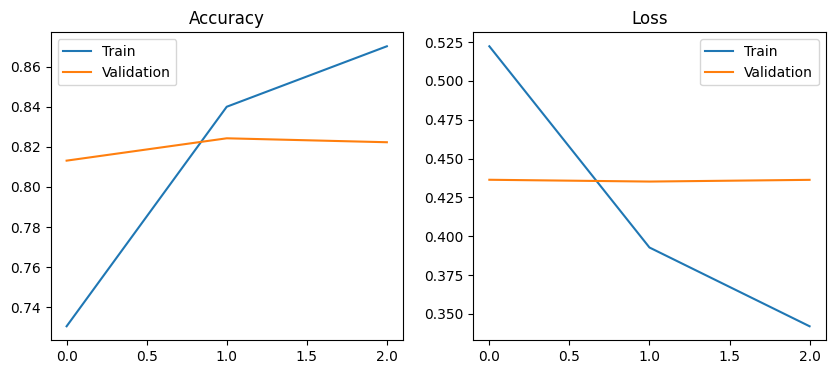

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()

**Insights:**

- The training accuracy continues to rise, but validation accuracy peaks and then slightly dips.
- Training loss decreases steadily, but validation loss increases at the final epoch.
- This suggests that the model may be starting to overfit after epoch 1. Early stopping was applied.



In [45]:
# 6. Generate Predictions and Metrics
# 1. Get predictions (ensure output is numpy array)
y_pred_probs = tf.sigmoid(classifier.predict(X_test.tolist())).numpy()

# 2. Convert to binary predictions (2 methods)
# Method 1: Using numpy
y_pred = (y_pred_probs > 0.5).astype(int)

# Method 2: Using TensorFlow (alternative)
# y_pred = tf.cast(tf.math.greater(y_pred_probs, 0.5), tf.int32).numpy()

# 3. Classification Report
from sklearn.metrics import classification_report
print("Validation Set Classification Report DistilBERT Model")
print(classification_report(y_test, y_pred, target_names=['Not Disaster', 'Disaster']))


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step
Validation Set Classification Report DistilBERT Model
              precision    recall  f1-score   support

Not Disaster       0.82      0.90      0.86       869
    Disaster       0.84      0.74      0.79       654

    accuracy                           0.83      1523
   macro avg       0.83      0.82      0.82      1523
weighted avg       0.83      0.83      0.83      1523



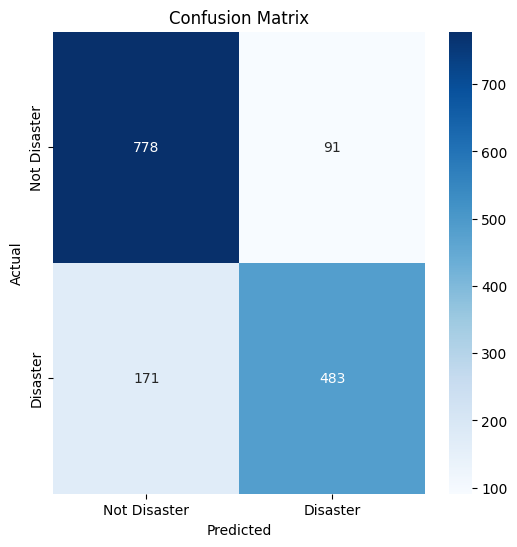

In [46]:
# 4. Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Disaster', 'Disaster'],
            yticklabels=['Not Disaster', 'Disaster'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-47-b33e8ffba55a>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score (Disaster)', y='Model', data=df.sort_values('F1-Score (Disaster)', ascending=False), palette='viridis')


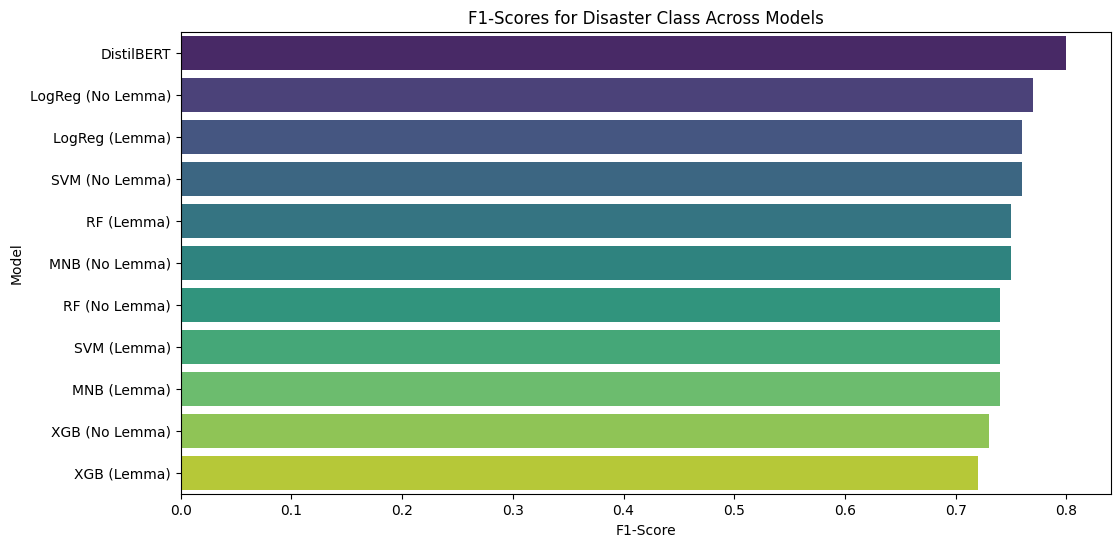

In [47]:
# Dataframe of F1-scores (Disaster class)
models = ['LogReg (Lemma)', 'RF (Lemma)', 'XGB (Lemma)', 'SVM (Lemma)', 'MNB (Lemma)',
          'LogReg (No Lemma)', 'RF (No Lemma)', 'XGB (No Lemma)', 'SVM (No Lemma)', 'MNB (No Lemma)', 'DistilBERT']
f1_scores = [0.76, 0.75, 0.72, 0.74, 0.74, 0.77, 0.74, 0.73, 0.76, 0.75, 0.80]

df = pd.DataFrame({'Model': models, 'F1-Score (Disaster)': f1_scores})

plt.figure(figsize=(12, 6))
sns.barplot(x='F1-Score (Disaster)', y='Model', data=df.sort_values('F1-Score (Disaster)', ascending=False), palette='viridis')
plt.title('F1-Scores for Disaster Class Across Models')
plt.xlabel('F1-Score')
plt.show()

- DistilBert had the highest F1-Score

<ipython-input-48-b1073ab8ff7d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Precision', y='Model', data=df_precision, palette='Blues_d')


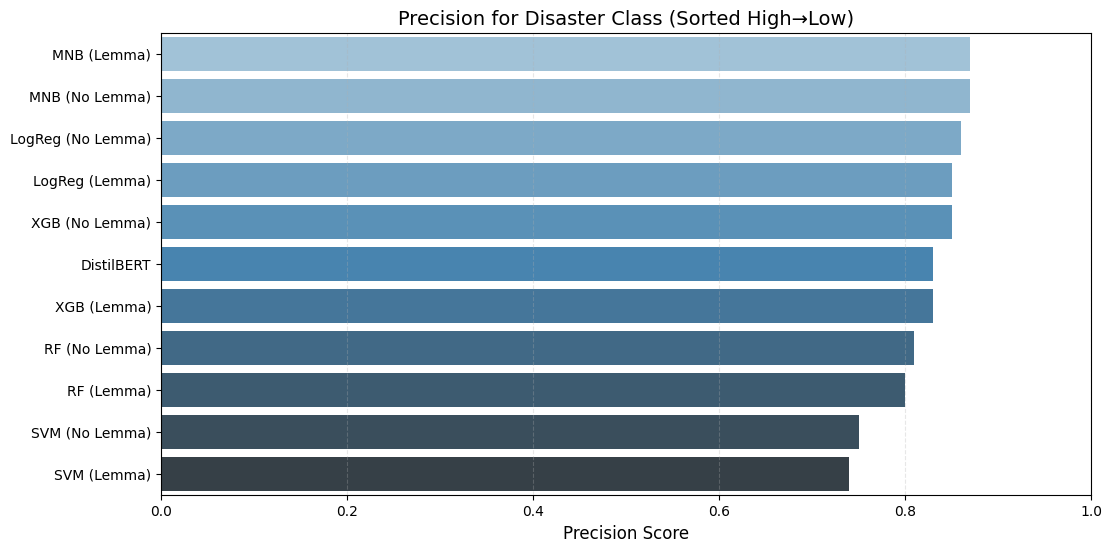

In [48]:
# Data preparation
models = ['LogReg (Lemma)', 'RF (Lemma)', 'XGB (Lemma)', 'SVM (Lemma)', 'MNB (Lemma)',
          'LogReg (No Lemma)', 'RF (No Lemma)', 'XGB (No Lemma)', 'SVM (No Lemma)', 'MNB (No Lemma)', 'DistilBERT']
precision = [0.85, 0.80, 0.83, 0.74, 0.87, 0.86, 0.81, 0.85, 0.75, 0.87, 0.83]
recall = [0.69, 0.71, 0.64, 0.75, 0.64, 0.70, 0.68, 0.64, 0.76, 0.66, 0.77]

# Create and sort precision dataframe
df_precision = pd.DataFrame({'Model': models, 'Precision': precision})
df_precision = df_precision.sort_values('Precision', ascending=False)

# Precision plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Precision', y='Model', data=df_precision, palette='Blues_d')
plt.title('Precision for Disaster Class (Sorted High→Low)', fontsize=14)
plt.xlabel('Precision Score', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

- Multinomial Naive Bayes had the highest precision.

<ipython-input-49-686ba916a417>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recall', y='Model', data=df_recall, palette='Reds_d')


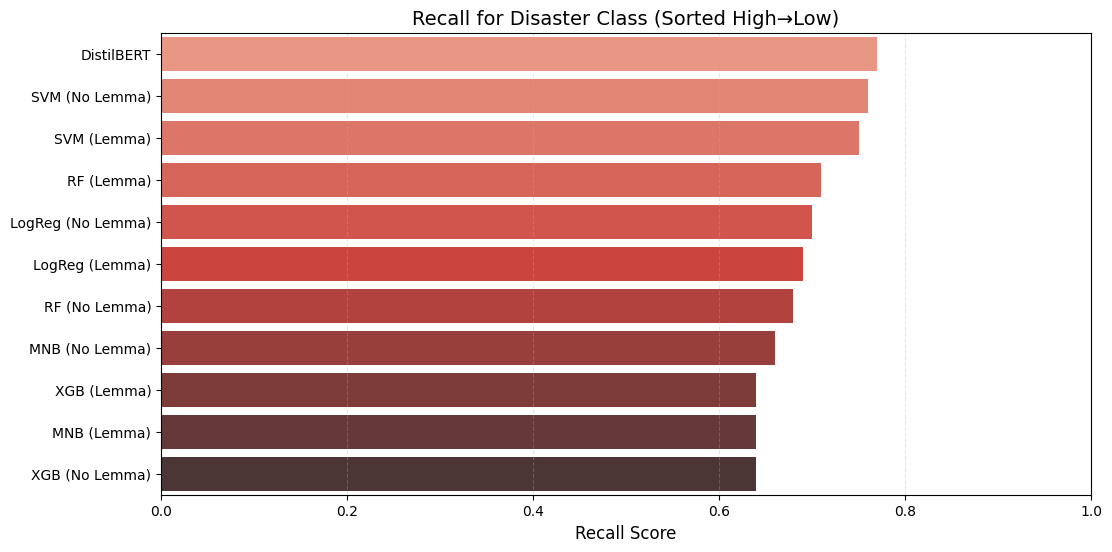

In [49]:
# Create and sort recall dataframe
df_recall = pd.DataFrame({'Model': models, 'Recall': recall})
df_recall = df_recall.sort_values('Recall', ascending=False)

# Recall plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Recall', y='Model', data=df_recall, palette='Reds_d')
plt.title('Recall for Disaster Class (Sorted High→Low)', fontsize=14)
plt.xlabel('Recall Score', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

- DistilBERT had the highest recall.

<ipython-input-50-e8e1e2e138ce>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_accuracy, palette='Greens_d')


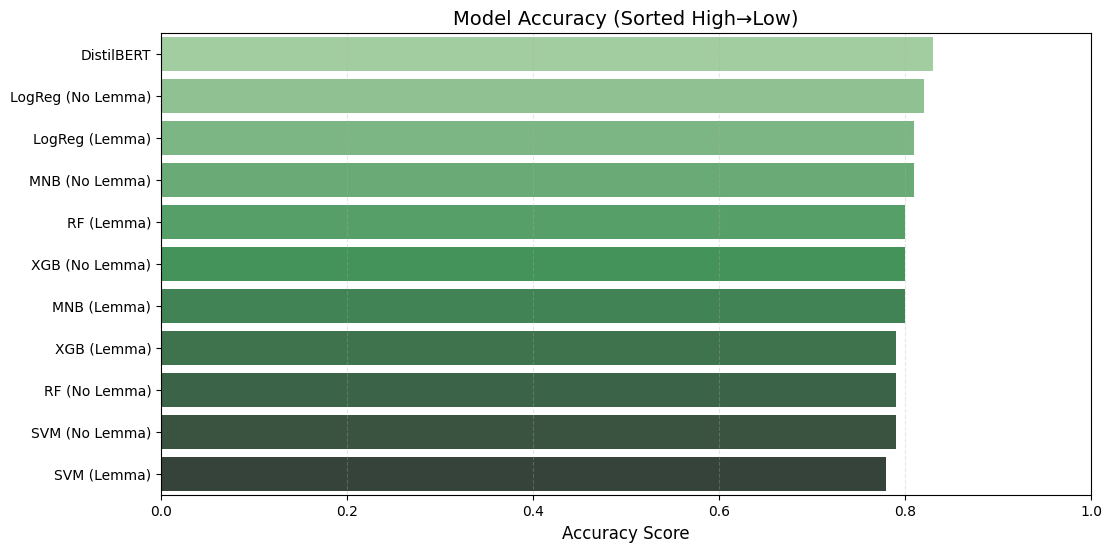

In [50]:
# Accuracy data
accuracy = [0.81, 0.80, 0.79, 0.78, 0.80, 0.82, 0.79, 0.80, 0.79, 0.81, 0.83]

# Create and sort accuracy dataframe
df_accuracy = pd.DataFrame({'Model': models, 'Accuracy': accuracy})
df_accuracy = df_accuracy.sort_values('Accuracy', ascending=False)

# Accuracy plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Accuracy', y='Model', data=df_accuracy, palette='Greens_d')
plt.title('Model Accuracy (Sorted High→Low)', fontsize=14)
plt.xlabel('Accuracy Score', fontsize=12)
plt.ylabel('')
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

- DistilBERT had the highest model accuracy

## Summary
---

Precision
- How reliable are our disaster alerts?
- Critical when false alarms are costly.

Recall:
- Did we catch all the real disasters?
- Vital for life threatening evemts

F1-score:
- Balances precision and recall

Accuracy:
- Overall correctness
- Can be misleading if the dataset is imbalanced.



In disaster response, the choice between precision and recall hinges on risk tolerance: missing a true disaster (low recall) may cost lives, while false alarms (low precision) waste resources. The results suggest the DistilBERT model offer the best compromise.

## References
----

[1] Firoj Alam, Tanvirul Alam, Md. Arid Hasan, Abul Hasnat, Muhammad Imran, Ferda Ofli, MEDIC: A Multi-Task Learning Dataset for Disaster Image Classification. Neural Computing and Applications, 35(3):2609–2632, 2023. [Bibtex] [Arxiv]

[2] Muhammad Imran, Umair Qazi, Ferda Ofli. TBCOV: Two Billion Multilingual COVID-19 Tweets with Sentiment, Entity, Geo, and Gender Labels. Data. 2022; 7(1):8. https://doi.org/10.3390/data7010008. [arXiv | bibtex]

[3] Sit, M. A., Koylu, C., & Demir, I. (2019). Identifying disaster-related tweets and their semantic, spatial and temporal context using deep learning, natural language processing and spatial analysis: a case study of Hurricane Irma. International Journal of Digital Earth, 12(11), 1205–1229. https://doi.org/10.1080/17538947.2018.1563219

[4] Powers, C. J., Devaraj, A., Ashqeen, K., Dontula, A., Joshi, A., Shenoy, J., & Murthy, D. (2023). Using artificial intelligence to identify emergency messages on social media during a natural disaster: A deep learning approach. International Journal of Information Management Data Insights, 3(1), 100164.

[5] Mendon, S., Dutta, P., Behl, A., & Lessmann, S. (2021). A hybrid approach of machine learning and lexicons to sentiment analysis: enhanced insights from twitter data of natural disasters. Information Systems Frontiers, 23(5), 1145-1168.